# Matching the B18 Lab calibration with `edges-cal`

This memo notebook summarizes the results of careful matching of the EDGES-2 calibration with `edges-cal` to the output of Alan's C-code for the precise parameters used for the `H2` case in Bowman+2018. 

The main result of this memo is that `edges-cal` **can now match the C-code to better than $10^{-7}$ precision** in the calibration parameters ($C_1$, $C_2$, $T_{\rm unc}$, $T_{\rm cos}$ and $T_{\rm sin}$). 

The format of this memo is very similar to [Memo #205](http://loco.lab.asu.edu/loco-memos/edges_reports/EDGES_Memo_205_v1.pdf), which performed the same analysis for EDGES-3. Since during that analysis we found some small bugs both in `edges-cal` and in the C-code, this memo shows the effect of fixing those bugs in reproducing B18.

## The Data & C-Code

The data and C-code used in this memo are in the [alans-pipeline](https://github.com/edges-collab/alans-pipeline) repository. Specifically, the final calibration coefficients, in the `specal.txt` file(s), *exactly* match those produced with the [nature-paper-case-h2](https://github.com/edges-collab/alans-pipeline/releases/tag/nature-paper-case-h2) tag of that repo. However, we use an updated version of that repo here [TAG TO COME!!!], which has simplified the script, removing unnecessary parameters, and also adds several more intermediate output files, and increases the precision of some of the output files.

More specifically, the data for this comparison are:

* **S11s**: calibrated by Raul and stored in the file [s11_calibration_low_band_LNA25degC_2015-09-16-12-30-29_simulator2_long.txt](https://github.com/edges-collab/alans-pipeline/blob/main/data/s11_calibration_low_band_LNA25degC_2015-09-16-12-30-29_simulator2_long.txt)
* **Load Spectra**: All spectra are from `/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/Spectra`:
    * `Ambient`: 
        * `Ambient_01_2015_245_02_00_00_lab.acq`
        * `Ambient_01_2015_246_02_00_00_lab.acq`
    * `HotLoad`:
        * `HotLoad_01_2015_246_04_00_00_lab.acq`
        * `HotLoad_01_2015_247_00_00_00_lab.acq`
    * `LongCableOpen`:
        * `LongCableOpen_01_2015_243_14_00_00_lab.acq`
        * `LongCableOpen_01_2015_244_00_00_00_lab.acq`
        * `LongCableOpen_01_2015_245_00_00_00_lab.acq`
    * `LongCableShorted`:
        * `LongCableShorted_01_2015_241_04_00_00_lab.acq`
        * `LongCableShorted_01_2015_242_00_00_00_lab.acq`
        * `LongCableShorted_01_2015_243_00_00_00_lab.acq`
        

The C-code was run according to the README of the [alans-pipeline](https://github.com/edges-collab/alans-pipeline) repo, specifically by running the `scripts/run-H2-cal` C-shell script.

### C-Code Modifications

In [Memo #205](http://loco.lab.asu.edu/loco-memos/edges_reports/EDGES_Memo_205_v1.pdf) we described a small bug in `edges3.c` in which the `fittp()` function used one less channel than it should have when fitting S11's. This bug exists in `edges2k.c`, and we modified the code to be able to compile with and without the bug. We show results from both in this memo.

## Python Code

Similar to the `alancal` command introduced and described in [Memo #205](http://loco.lab.asu.edu/loco-memos/edges_reports/EDGES_Memo_205_v1.pdf), there is a new CLI interface in `edges-cal` called `alancal2`, which uses `edges-cal` machinery to run calibration solutions as close as possible to the C-code. 

In this memo, we used the following command to produce the outputs:

```
SPEC=/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/Spectra
edges-cal alancal2 --s11-path ../data/s11_calibration_low_band_LNA25degC_2015-09-16-12-30-29_simulator2_long.txt \
    --ambient-acqs ${SPEC}/Ambient_01_2015_245_02_00_00_lab.acq --ambient-acqs ${SPEC}/Ambient_01_2015_246_02_00_00_lab.acq \
    --hotload-acqs ${SPEC}/HotLoad_01_2015_246_04_00_00_lab.acq --hotload-acqs ${SPEC}/HotLoad_01_2015_247_00_00_00_lab.acq \
    --open-acqs ${SPEC}/LongCableOpen_01_2015_243_14_00_00_lab.acq --open-acqs ${SPEC}/LongCableOpen_01_2015_244_00_00_00_lab.acq \
    --open-acqs ${SPEC}/LongCableOpen_01_2015_245_00_00_00_lab.acq --short-acqs ${SPEC}/LongCableShorted_01_2015_241_04_00_00_lab.acq \
    --short-acqs ${SPEC}/LongCableShorted_01_2015_242_00_00_00_lab.acq --short-acqs ${SPEC}/LongCableShorted_01_2015_243_00_00_00_lab.acq \
    -fstart=40.0 -fstop=110.0 -wfstart=50.0 -wfstop=100.0 -smooth=8 -tload=300.0 -tcal=1000.0  -tstart=0 -tstop=23 \
    -delaystart=7200 -Lh=-2 -tcold=296 -thot=399 -cfit=6 -wfit=5 -nfit2=27 -nfit3=11 --lna-poly=0
```

As can be seen, the input arguments to the CLI are, whenever possible, the same as the inputs to the C-code binaries. 

### Fixes to `edges-cal` required to get these results

Starting from the version of `edges-cal` that reproduces the EDGES-3 results in Memo 205, there was one more substantial fix required to obtain matching results for this memo using EDGES-2 data. This fix was that in the hot-load loss function, which uses the semi-rigid cable S-parameters, there was a single instance where the $S_{11}$ was used where it should have been $S_{22}$. This has now been fixed. 

## The Comparisons

In [1]:
from edges_cal.alanmode import acqplot7amoon, edges
from pathlib import Path
from edges_cal.alanmode import read_s11_csv, read_spec_txt, read_specal, read_raul_s11_format, write_specal, write_modelled_s11s
import numpy as np
from astropy import units as un
from edges_cal.s11 import S11Model, LoadS11, Receiver
from edges_cal.tools import FrequencyRange
from edges_cal import modelling as mdl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def read_s11m(pth):
    _s11m = np.genfromtxt(pth, comments="#", names=True)
    s11m = {}
    freq = _s11m['freq']
    for name in _s11m.dtype.names:
        if name == 'freq':
            continue

        bits = name.split("_")
        cmp = bits[-1]
        load = "_".join(bits[:-1])

        if load not in s11m:
            s11m[load] = np.zeros(len(_s11m), dtype=complex)
        if cmp == 'real':
            s11m[load] += _s11m[name]
        else:
            s11m[load] += _s11m[name]*1j

    return freq, pd.DataFrame(s11m)

In [3]:
outpath = Path("edges-cal-outputs")

### Check Modelling of S11's

In [19]:
alancalfreq, alans11m = read_s11m("scripts/H2Case/s11_modelled.txt")
alancalfreq, alans11m_fixtp = read_s11m("scripts/H2Case-fittpfix/s11_modelled.txt")

calfreq, ours11m = read_s11m(outpath/'s11_modelled.txt')

In [20]:
alanmask = (alancalfreq >= 50.0) & (alancalfreq <= 100.0)

In [21]:
alans11m = alans11m[alanmask]
alans11m_fixtp = alans11m_fixtp[alanmask]


In [49]:
alan_s11m_cases = {
    'With fittp() fix': alans11m_fixtp,
    'Original': alans11m
}

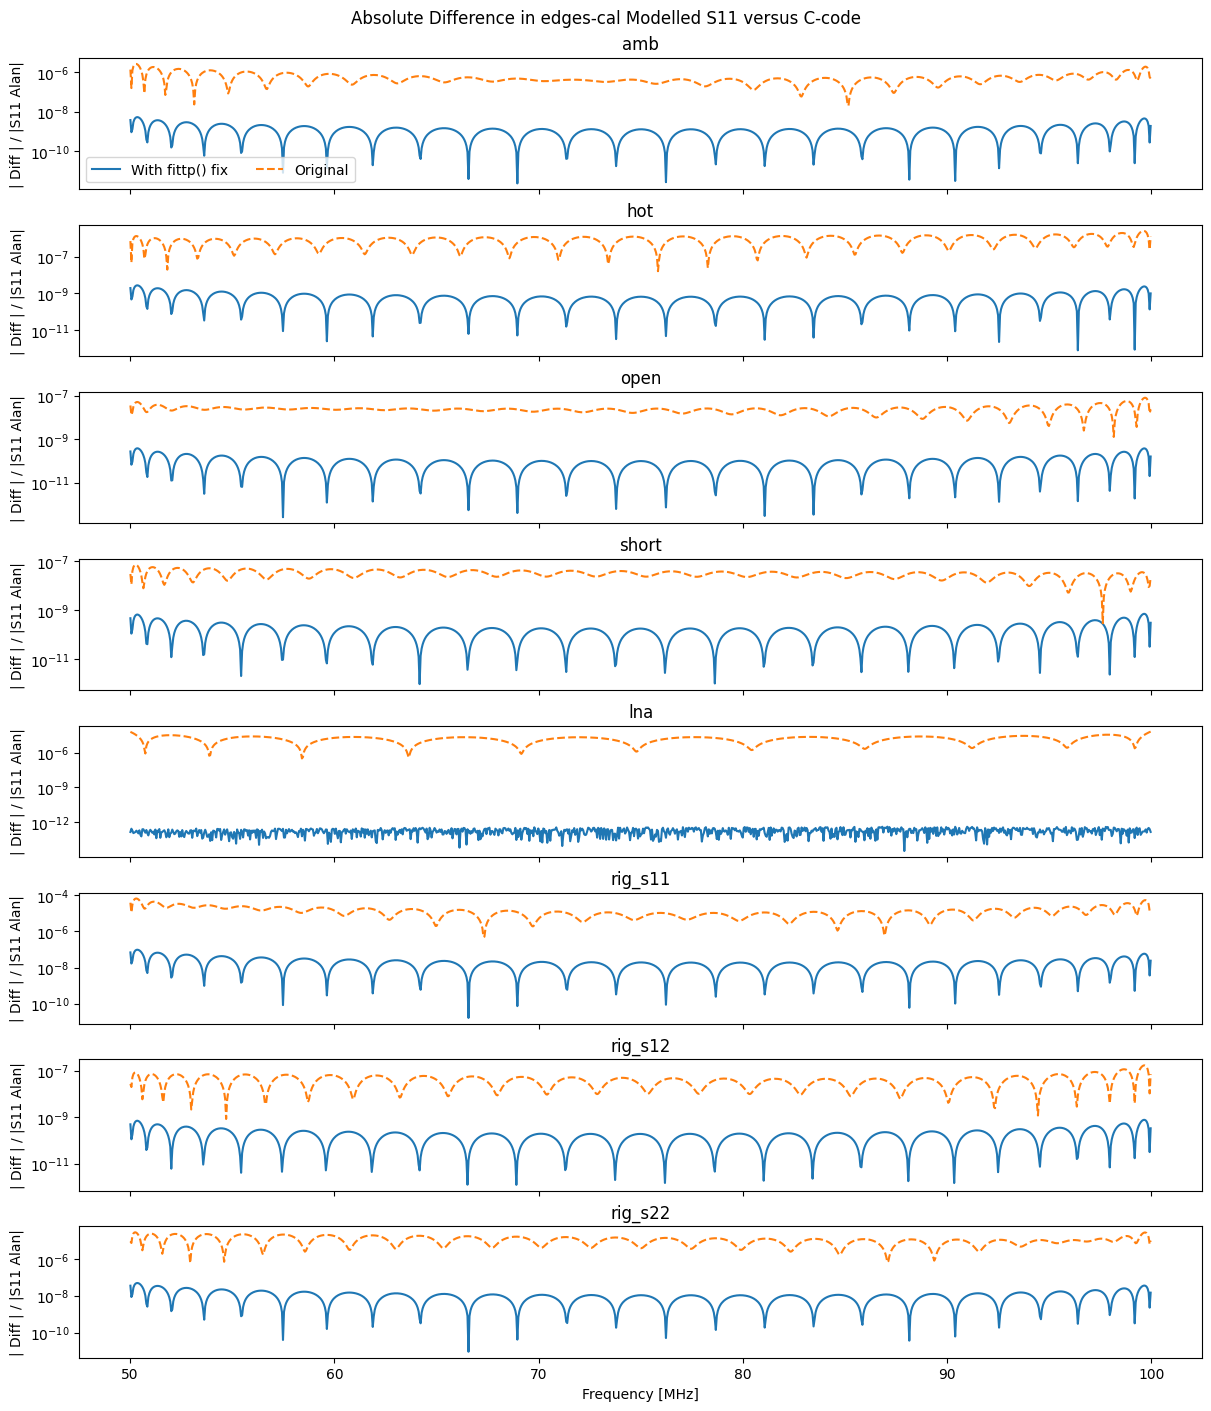

In [51]:
fig, ax = plt.subplots(len(alans11m.keys()), 1, sharex=True, constrained_layout=True, figsize=(12, 14))

for j, (case, _as11) in enumerate(alan_s11m_cases.items()):
    for i, load in enumerate(ours11m.keys()):
        us = ours11m[load].to_numpy()
        al = _as11[load].to_numpy()
        ax[i].plot(calfreq, np.abs(al - us)/np.abs(al), label=case, ls=['-', '--'][j%2])
        ax[i].set_title(load)
        ax[i].set_yscale('log')
        ax[i].set_ylabel("| Diff | / |S11 Alan|")
        
ax[0].legend(ncols=2)
ax[-1].set_xlabel("Frequency [MHz]")
fig.suptitle("Absolute Difference in edges-cal Modelled S11 versus C-code");

**Figure 1 |** Comparison of smoothed/modelled $S_{11}$ values for all loads, including receiver and semi-rigid cable, between `edges-cal` and the C-code. Each panel represents a different load, and the two colors/linestyles in each panel represent two different cases of the C-code: with and without the fix to `fittp()` (see above for description). These values are used *in memory* in both the C-code and `edges-cal`, so they are used at high precision (we write them out here with 16 decimals, so the differences look smooth). With the `fittp()` fix (blue solid) the relative errors are generally less than one part in $10^8$. 

### Check Spectrum Averaging

In [11]:
def read_all_avspec(direc: Path):
    spec = {}
    allfiles = direc.glob("spe_*r.txt")
    for fl in allfiles:
        load = fl.name.split("_")[1][:-5]
        s = read_spec_txt(fl)
        spec[load] = s['spectra']
        freq = s['freq']
    return freq, spec

In [12]:
spfreq, alanspec = read_all_avspec(Path("scripts/H2Case"))
spfreq, ourspec = read_all_avspec(outpath)

Text(0.5, 0.98, 'Raw spectra differences')

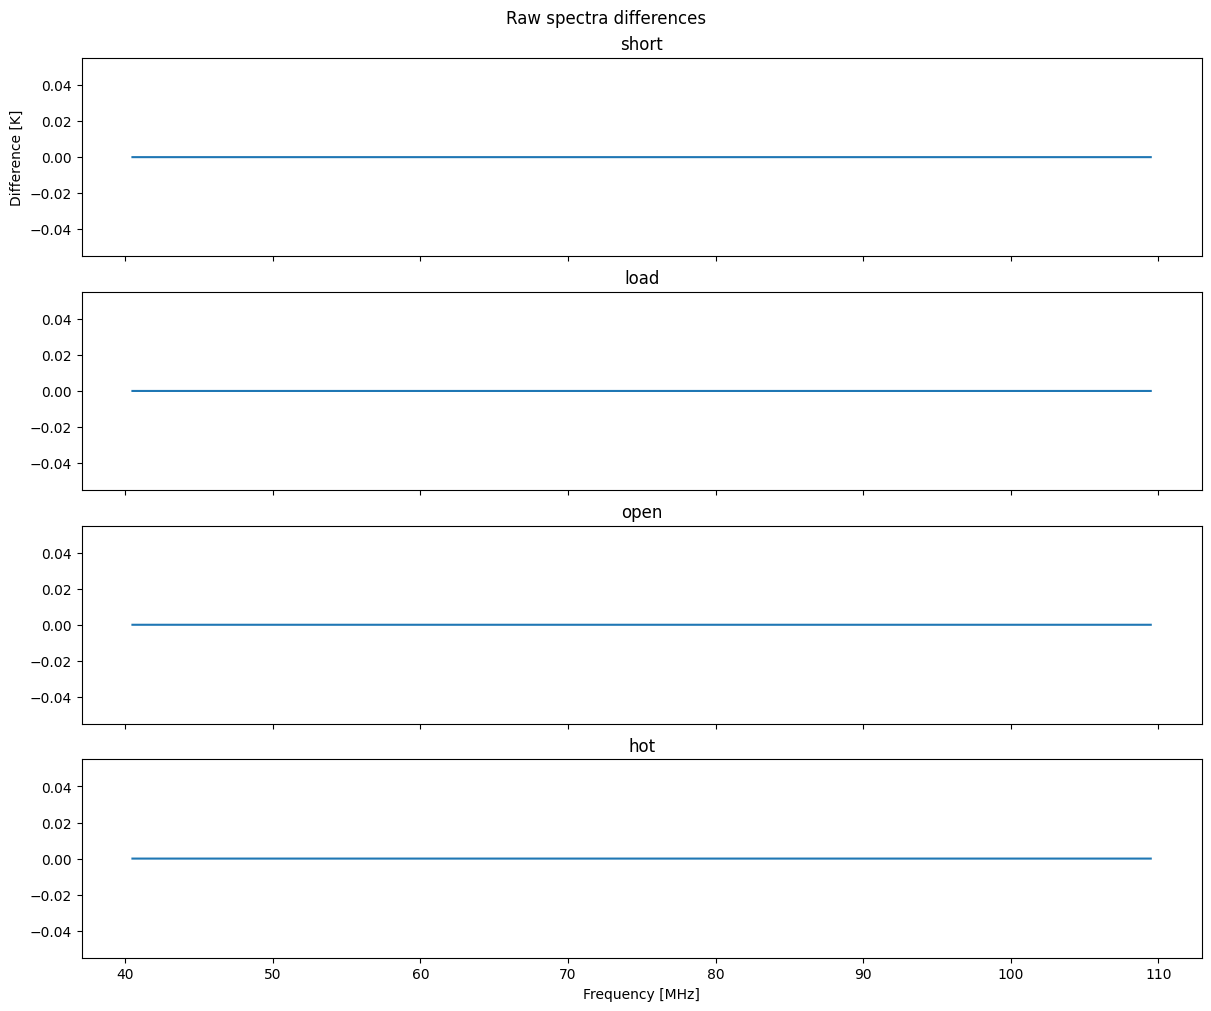

In [13]:
fig, ax = plt.subplots(len(alanspec), 1, sharex=True, constrained_layout=True, figsize=(12, 10))
for i, load in enumerate(alanspec):
    ax[i].plot(spfreq[10:-10], alanspec[load][10:-10] - ourspec[load][10:-10])
    ax[i].set_title(load)
    ax[0].set_ylabel("Difference [K]")
    
ax[-1].set_xlabel("Frequency [MHz]")
fig.suptitle("Raw spectra differences")

**Figure 2 |** Comparison of output averaged uncalibrated spectra from `acqplot7amoon` for each load. The differences here are exactly zero between the two pipelines. The precision of the files output is quite low: only six decimal places, so the exact correspondence here only indicates correspondence to this precision. However, since this data is only ever used after being written out and then read from these files (both in the C-code and in the `alancal` command), this ensures exact correspondence between the pipelines.

### Check Hot Load Loss

In [79]:
alans_hot_load_loss = np.genfromtxt("scripts/H2Case/hot_load_loss.txt")
our_hot_load_loss = np.genfromtxt(outpath / 'hot_load_loss.txt')

Text(0.5, 1.0, 'Difference in hot load loss model')

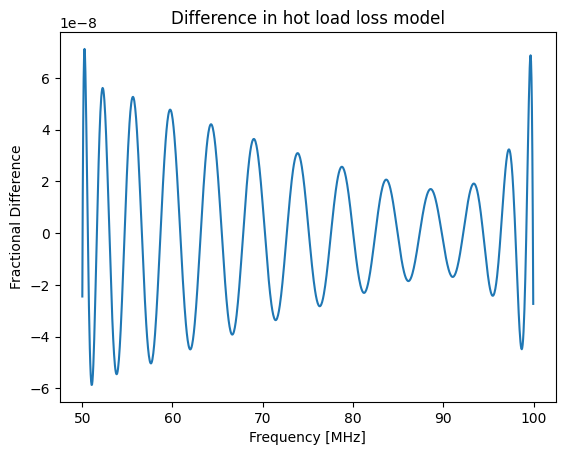

In [82]:
plt.plot(calfreq, our_hot_load_loss[:, 1] / alans_hot_load_loss[alanmask, 1] - 1)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Fractional Difference")
plt.title("Difference in hot load loss model")

**Figure 3 |** Fractional difference in the hot load loss model.

### Check Calibration Coefficients

In [29]:
ourcal = read_specal(outpath / 'specal.txt')
ourcalint = read_specal(outpath / 'specal-interactive.txt')

In [22]:
alancal_orig = read_specal("scripts/H2Case/specal.txt")[alanmask]

In [23]:
alancal_fitp = read_specal("scripts/H2Case-fittpfix/specal.txt")[alanmask]

In [24]:
alancal_cases = {
    "With fittp() fix": alancal_fitp,
    "Original": alancal_orig,
}

In [33]:
def plot_calcoeff_cases(cases, comp_case, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(len(comp_case.dtype.names)-2, 1, sharex=True, constrained_layout=True, figsize=(12, 15))

    for ic, (case, cal) in enumerate(cases.items()):
        j = 0
        
        for i, name in enumerate(comp_case.dtype.names):
            if name in ('freq', 'weight'):
                continue
                
            ax[j].plot(comp_case['freq'], np.abs(comp_case[name] - cal[name]), label=case, ls=['-', '--'][ic%2])
            
            #ax[j].set_yscale('log')
            ax[j].set_title(name)
            if name.startswith("T"):
                ax[j].set_ylabel("Difference [K]")
            else:
                ax[j].set_ylabel("Difference")
            j += 1

    ax[0].legend()
    ax[-1].set_xlabel("Frequency [MHz]")
    
    return fig, ax

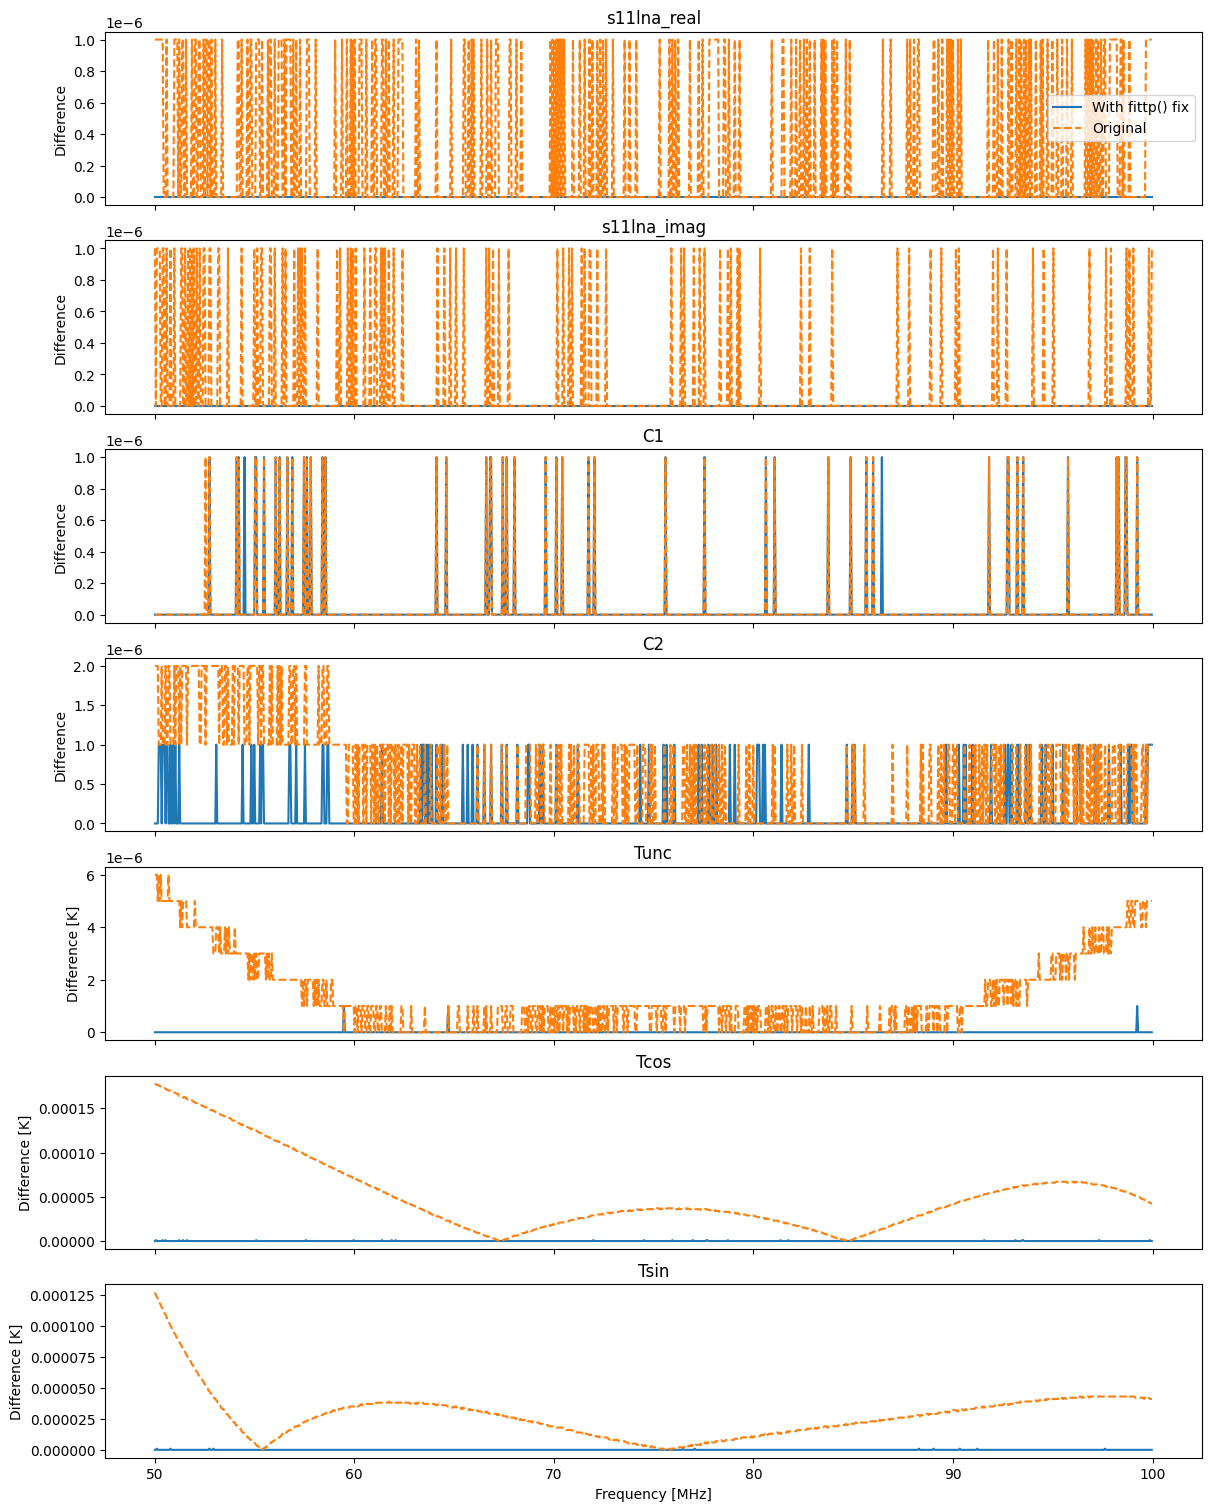

In [34]:
plot_calcoeff_cases(alancal_cases, ourcal);

**Figure 4 |** Absolute differences between calibration coefficients and LNA $S_{11}$, as saved in the `specal.txt` file from the `edges2k.c` pipeline. Different colors represent different cases of the C-code: with and without the fix to `fittp()`, as described above. With the fix (blue solid), the differences are always with $10^{-6}$, which is the precision of the output file. Without the fix (orange dashed), the noise-wave parameters $T_{\rm cos}$ and $T_{\rm sin}$ have larger differences, on the order of 0.1 mK. 

One thing that potentially should be noted is that the precision of the output `specal.txt` file, which is the file used for performing calibration on field data, is actually quite low, with just six decimal places. For $C_1$, which is a multiplicative gain, this translates to about 10 mK for sky temperatures of $10^4$ K. My suggestion would be to increase this precision by at least a couple of decimal places, to ensure it is well below the noise level.